# I - Urban/Rural Designation and County Elections

In [1]:
import pandas as pd
import numpy as np
import altair as alt

In [2]:
from ETL.EtlCovid import *
from ETL.EtlElection import *
from ETL.EtlVaccine import *
from ETL.EtlUrbanRural import *
from Visualization.VizBase import *
from Visualization.VizCovid import *
from Visualization.VizVaccine import *
from Visualization.VizMask import *
from Visualization.VizUrbanRural import *

In [3]:
#alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

## A- County Urban/Rural Designation

In [4]:

SomeDF = GetCountyUrbanRuralData()
SomeDF.head()

,county_fips,UrbanRural,PctRural
0,1001,urban,42.002162
1,1003,urban,42.279099
2,1005,rural,67.789635
3,1007,rural,68.352607
4,1009,rural,89.951502


## B- County Election Data

In [5]:

SomeDF = GetCountyElectionData()
SomeDF.head()

,state_po,county_name,county_fips,candidate,party,candidatevotes,totalvotes
50526,AL,AUTAUGA,1001,DONALD J TRUMP,REPUBLICAN,19838.0,27770.0
50529,AL,BALDWIN,1003,DONALD J TRUMP,REPUBLICAN,83544.0,109679.0
50532,AL,BARBOUR,1005,DONALD J TRUMP,REPUBLICAN,5622.0,10518.0
50535,AL,BIBB,1007,DONALD J TRUMP,REPUBLICAN,7525.0,9595.0
50538,AL,BLOUNT,1009,DONALD J TRUMP,REPUBLICAN,24711.0,27588.0


### 1. Clean the county FIPS codes

### 2. Clean up several data issues

## C- Merge the dataframes

In [6]:

PEUrbanRuralDF = MergeElectionUrbanRural()
PEUrbanRuralDF.head()

,state_po,county_name,county_fips,candidate,party,candidatevotes,totalvotes,UrbanRural,PctRural
0,AL,AUTAUGA,1001,DONALD J TRUMP,REPUBLICAN,19838.0,27770.0,urban,42.002162
1,AL,BALDWIN,1003,DONALD J TRUMP,REPUBLICAN,83544.0,109679.0,urban,42.279099
2,AL,BARBOUR,1005,DONALD J TRUMP,REPUBLICAN,5622.0,10518.0,rural,67.789635
3,AL,BIBB,1007,DONALD J TRUMP,REPUBLICAN,7525.0,9595.0,rural,68.352607
4,AL,BLOUNT,1009,DONALD J TRUMP,REPUBLICAN,24711.0,27588.0,rural,89.951502


<b>NOTE:</b> Some of the missing data represents small numbers. For the rest:<br>
o- Most are in Alaska. An internet search shows no clear way to confirm the county names or connect the urban/rural designation to the election data.<br>
o- One is for Kansas City, but it isn't clear if this is for the whole city or for the region in Missouri only.

So this data will be dropped. It represents less than 1% of all the data, and the remainder will be enough to investigate the relationships between political ideology and the urban/rural designation.

Reminder that 13 Vermont counties were also dropped above for similar reasons.

## D- Plot the data

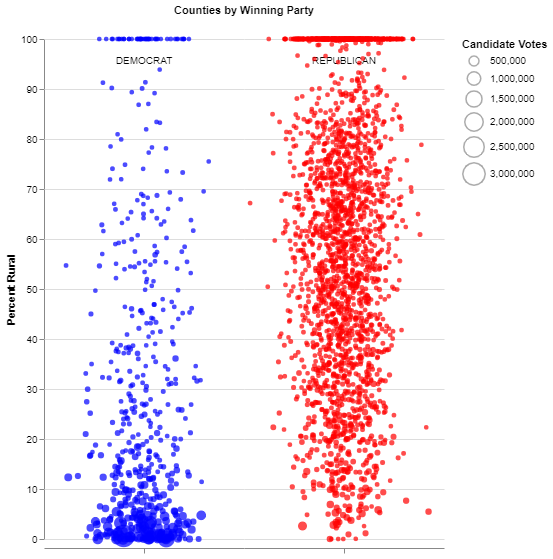

In [7]:
def ElectionUrbanRuralStripPlot():
    '''
    Plots the urban/rural designation of the counties merged with the county-level
        presidential election results as a strip plot by party
    Returns a chart showing:
        x-axis: party - categorical - Winning candidate's party
        y-axis: PctRural - quantitative - Percentage of "how rural" a county is
    
    Called by: Main code
    Functions called: MergeElectionUrbanRural()
    '''

    PEUrbanRuralDF = MergeElectionUrbanRural()

    # Source: https://altair-viz.github.io/gallery/stripplot.html

    # Need to disable the error since data is more than 5k rows
    alt.data_transformers.disable_max_rows()

    domain = ['DEMOCRAT', 'REPUBLICAN']
    range_ = ['blue', 'red']

    stripplot =  alt.Chart(PEUrbanRuralDF, width=200, height=500).mark_point(filled=True, size=18).encode(
        x=alt.X(
            'jitter:Q',
            title=None,
            axis=alt.Axis(values=[0], ticks=True, grid=False, labels=False),
            scale=alt.Scale(),
        ),
        y=alt.Y('PctRural:Q', title='Percent Rural'),
        color=alt.Color('party:N', scale=alt.Scale(domain=domain, range=range_),
                       title='Party', legend=None),
        size = alt.Size('candidatevotes:Q', scale=alt.Scale(range=[20, 500],zero=False), 
                        title='Candidate Votes', legend=alt.Legend(symbolFillColor='white')),
        column=alt.Column(
            'party:N',
            header=alt.Header(
                labelAngle=0,
                titleOrient='top',
                labelOrient='bottom',
                labelAlign='center',
                labelPadding=30,
                title='Counties by Winning Party',
            ),
        ),
    ).transform_calculate(
        # Generate Gaussian jitter with a Box-Muller transform
        jitter='sqrt(-2*log(random()))*cos(2*PI*random())'
    ).configure_facet(
        spacing=0
    ).configure_view(
        stroke=None
    )
    
    return stripplot

SomePlot = ElectionUrbanRuralStripPlot()
SomePlot

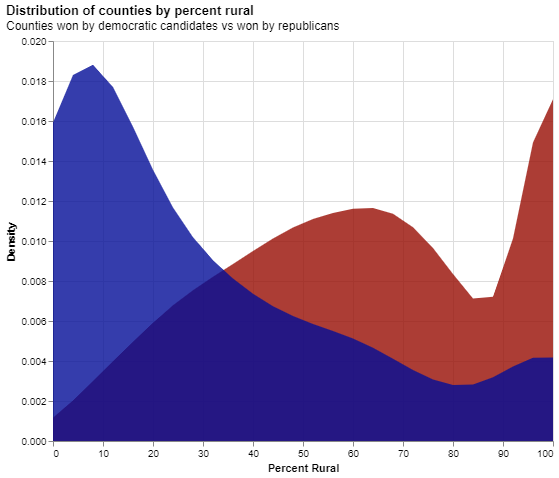

In [8]:

SomePlot = ElectionUrbanRuralDensityPlot(PEUrbanRuralDF)
SomePlot

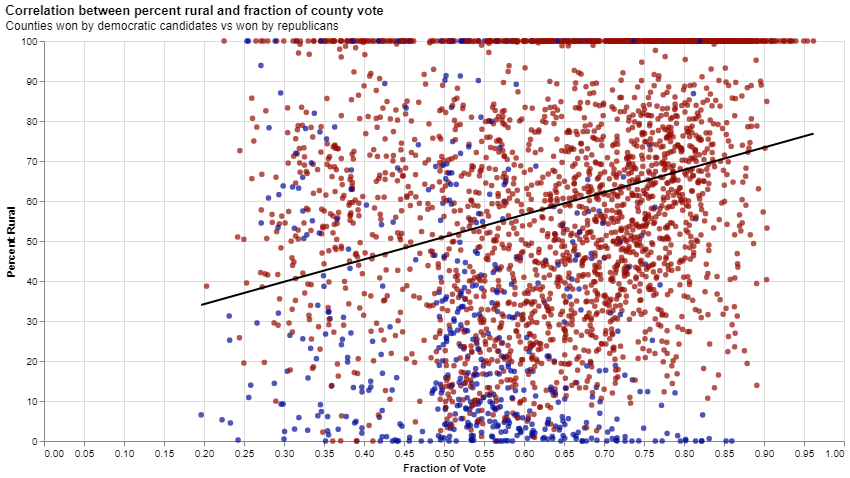

In [9]:
def FractionVotesPctRuralPlot():
    '''
    Plots the "percent rural" of counties vs fraction of the vote
        for the winning party
    Returns a chart showing:
        x-axis: Fraction of the vote - quantitative
        y-axis: PctRural - quantitative 
    
    Called by: Main code
    Functions called: MergeElectionUrbanRural()
    '''
    
    party_domain = ["DEMOCRAT", "REPUBLICAN"]
    party_range = ["#030D97", "#970D03"]

    PEUrbanRuralDF = MergeElectionUrbanRural()
    PEUrbanRuralDF2 = PEUrbanRuralDF.copy()
    PEUrbanRuralDF2['fractionvotes'] = PEUrbanRuralDF2['candidatevotes'] / PEUrbanRuralDF2['totalvotes']

    
    PctRuralDomain = [0, int(PEUrbanRuralDF2["PctRural"].max() / 10) * 10]
    
    # Prepare the chart
    voteplot = alt.Chart(
        PEUrbanRuralDF2,
        width=800,
        height=400,
        title={
            "text": [
                "Correlation between percent rural and fraction of county vote"
            ],
            "subtitle": ["Counties won by democratic candidates vs won by republicans",],
        }
    ).mark_point(filled=True, size=30).encode(
        y=alt.Y(
            "PctRural:Q",
            title="Percent Rural",
            scale=alt.Scale(
                domain=PctRuralDomain)
        ),
        x=alt.X(
            "fractionvotes:Q",
            title="Fraction of Vote",
            scale=alt.Scale(
                domain=[0, 1.0])),
        color=alt.Color("party:N", scale=alt.Scale(domain=party_domain, range=party_range),
                        title="Party", legend=None)
    )

    # This part doesn't make a whole lot of sense. It just adds a regression line that
    # says the more strongly a county votes in any direction, the more likely it is to
    # be a rural county. So rural voters are more likely to vote the same way?
    
    final_chart=(voteplot + voteplot.transform_regression("fractionvotes",
                                                          "PctRural").mark_line(
        color="black").encode(color=alt.value("black"))
    ).configure_title(
        align="left",
        anchor="start"
    )
    return final_chart

SomeChart = FractionVotesPctRuralPlot()
SomeChart

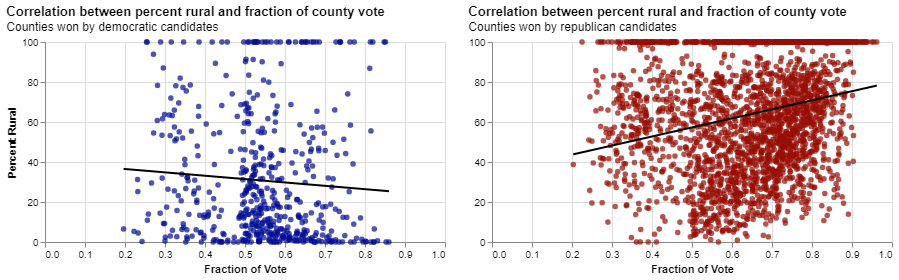

In [10]:

SomeChart = UrbanRuralCorrelation(PEUrbanRuralDF)
SomeChart

# II - Urban/Rural Designation and COVID Consequences

In [ ]:

EmptyDF = CountyElecUrbanRuralSplit()
type(EmptyDF)